## Exploring audio Data

In this section, we begin by importing the dataset from Hugging Face and proceed to conduct a preliminary analysis of its key features. The dataset used is the Common Voice 13.0 release by the Mozilla Foundation, which contains a diverse collection of voice recordings contributed by volunteers worldwide. Additional information about the dataset can be found [here](https://huggingface.co/datasets/mozilla-foundation/common_voice_13_0).

### Inspecting data fields

To begin, we will download the [Common Voice 17.0 dataset](https://huggingface.co/datasets/mozilla-foundation/common_voice_17_0) and inspect its structure. Our focus will be on German-language audio data for all subsequent analysis.

Downloading datasets from Hugging Face that are part of gated repositories requires an access token with appropriate permissions. Specifically, your token must have **read access** to public gated datasets. For more information on generating and managing access tokens, refer to the [Hugging Face Access Tokens documentation](https://huggingface.co/docs/hub/en/security-tokens).


In [2]:
from datasets import load_dataset_builder
from huggingface_hub import login

with open("./hugging_face_token") as f:
    token = f.read().strip()
login(token)

dataset_builder = load_dataset_builder("mozilla-foundation/common_voice_17_0", "de")
print(dataset_builder.info.features)
print(dataset_builder.info.description)

{'client_id': Value(dtype='string', id=None), 'path': Value(dtype='string', id=None), 'audio': Audio(sampling_rate=48000, mono=True, decode=True, id=None), 'sentence': Value(dtype='string', id=None), 'up_votes': Value(dtype='int64', id=None), 'down_votes': Value(dtype='int64', id=None), 'age': Value(dtype='string', id=None), 'gender': Value(dtype='string', id=None), 'accent': Value(dtype='string', id=None), 'locale': Value(dtype='string', id=None), 'segment': Value(dtype='string', id=None), 'variant': Value(dtype='string', id=None)}
Common Voice is Mozilla's initiative to help teach machines how real people speak. The dataset currently consists of 20408 validated hours of speech  in 124 languages, but more voices and languages are always added.


### Dataset Selection

The Common Voice dataset includes file paths and aligned audio-text pairs for training speech recognition models. Since the German subset exceeds 23 GB and is split into multiple archives, we limit our use to the `de_train_0` archive to conserve disk space. A copy of this archive, along with the extracted metadata, is provided in this repository. 

For more information, see the [Mozilla Common Voice dataset on Hugging Face](https://huggingface.co/datasets/mozilla-foundation/common_voice_17_0/tree/main/audio/de/train).


In [3]:
import pandas as pd
import os
import utils

data_path = "./common_voice/"
media_root = data_path + "de_train_0/"
metadata = data_path + "train_0.tsv"
if not os.path.exists(data_path):
    utils.download_data(data_path)
    df_original = pd.read_csv(data_path + "/train.tsv", sep="\t")
    df_data = pd.read_csv(metadata, sep="\t")
    print(f"Original Size: {df_original.shape[0]}, Set 0 Size: {df_data.shape[0]}", "\n")
    print(df_original.columns)
    

Now that we've extracted the relevant metadata, let's examine the structure of the first entry.

The sentence of the first entry: Alle Fluchtwege sind abgeschnitten.


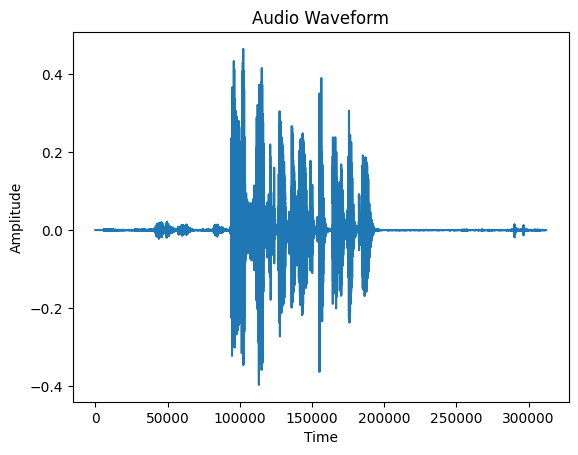

In [5]:
import torchaudio
import matplotlib.pyplot as plt
from IPython.display import Audio
df_data = pd.read_csv(metadata, sep="\t")
path = df_data.iloc[0]["path"]
transcript = df_data.iloc[0]["sentence"]
media_root = data_path + "/de_train_0/"
waveform, sample_rate = torchaudio.load(media_root + path)
print(f"The sentence of the first entry: {transcript}")
display(Audio(data=waveform.numpy(), rate=sample_rate))
plt.plot(waveform.t().numpy())
plt.title("Audio Waveform")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

In [47]:
import numpy as np
import warnings

# make a bar plot displaying all sample_rates
paths = df_data["path"]
num_data_points = len(paths)
rates = np.zeros(num_data_points)
duration = np.zeros(num_data_points)

for i, path in enumerate(paths):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        audio_meta = torchaudio.info(media_root + path)
    rates[i] = audio_meta.sample_rate
    duration[i] = audio_meta.num_frames / rates[i]


print(f"Sample rates: {rates}")
print(f"Num Frames per data point: {duration}")

Sample rates: [48000. 48000. 48000. ... 32000. 32000. 32000.]
Num Frames per data point: [6.509625 6.053625 6.773625 ... 5.8035   7.6755   7.2075  ]


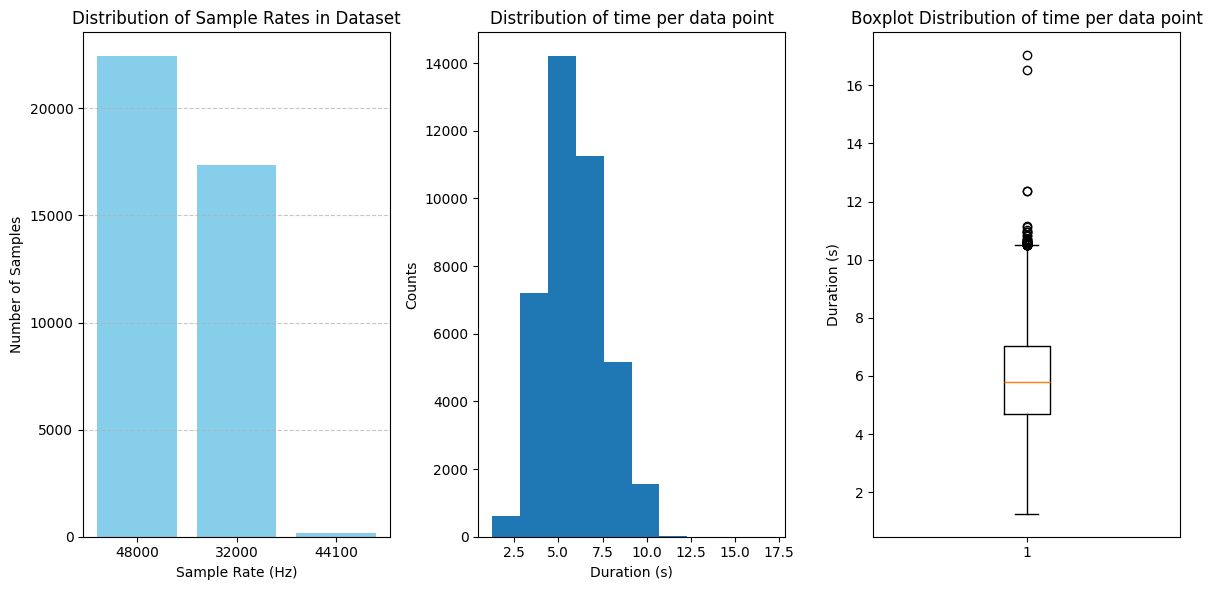

In [ ]:
from collections import Counter
# Count occurrences of each sample rate
rate_counts = Counter(rates)

# Prepare data for plotting
sample_rates = list(rate_counts.keys())
counts = list(rate_counts.values())

# Plot
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))
ax[0].bar([str(int(r)) for r in sample_rates], counts, color='skyblue')
ax[0].set_xlabel("Sample Rate (Hz)")
ax[0].set_ylabel("Number of Samples")
ax[0].set_title("Distribution of Sample Rates in Dataset")
ax[0].grid(axis='y', linestyle='--', alpha=0.7)

ax[1].hist(duration)
ax[1].set_xlabel("Duration (s)")
ax[1].set_ylabel("Counts")
ax[1].set_title("Distribution of time per data point")

ax[2].boxplot(duration)
ax[2].set_ylabel("Duration (s)")
ax[2].set_title("Boxplot Distribution of time per data point")

plt.tight_layout()
plt.show()

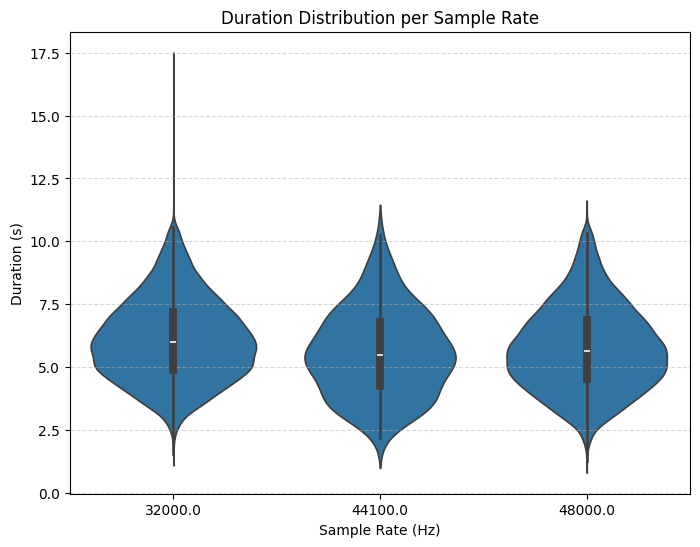

In [52]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame({
    "sample_rate": rates,
    "duration": duration
})

plt.figure(figsize=(8, 6))
sns.violinplot(x="sample_rate", y="duration", data=df)
plt.title("Duration Distribution per Sample Rate")
plt.xlabel("Sample Rate (Hz)")
plt.ylabel("Duration (s)")
plt.grid(True, axis="y", linestyle="--", alpha=0.5)
plt.show()

### Building the dataset

To efficiently process the downloaded data, we will construct a custom PyTorch dataset. For clarity and maintainability, the dataset implementation is placed in a separate Python module outside of this notebook.

In [ ]:
from utils import CommonVoiceDS
from torch.utils.data import DataLoader

Sample rates: [48000. 48000. 48000. ... 32000. 32000. 32000.]
Num Frames per data point: [312462. 290574. 325134. ... 185712. 245616. 230640.]


## The wav2vec model

## The whisper model

## How to combine wav2vec with whisper

## Fine tuning custom model

 ## Evaluation with Word Error Rate (WER) 